In [1]:
import base.dfBasics as dfBasics
import base.common as common
import base.encoder as encoder
import base.pfAdapt as pfAdapt
import base.charts as charts
#import base.anomaly as anomaly

import pandas as pd
from pyspark.sql import functions

Setup Complete


In [147]:
## Setup charts
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

def get_ym_string(a,b) :
    return a + "-" + b
    #return a.join(["-",b]) 

def get_ym(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    return a,b

def get_ymd(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    return a,b,c

def make_2digits(blist):
    for n, b in enumerate(blist):
        if int(b) < 10:
             blist[n] = '0' + str(b)
    return blist

def get_ymd_string(a,b,c) :
    if isinstance(a, str) :
        return a + "-" + make_2digits([b])[0] + "-" + make_2digits([c])[0] 
    return a + "-" + pd.Index(make_2digits(b.tolist())) + "-" + pd.Index(make_2digits(c.tolist())) 

def get_ymdh(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    d = mdcountsall.index.get_level_values(3).astype(str)
    return a,b,c,d

def get_ymdh_string(a,b,c,d) :
    return a + "-" + b + "-" + c + "-" + d

def createData_ym(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month'])['year'].count()    
    a,b = get_ym(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ym_string(a,b)
    data2['outcome'] = mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int) 
    return data2

def createData(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month','day','hour'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month','day','hour'])['year'].count()    
    a,b,c,d = get_ymdh(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymdh_string(a,b,c,d)
    data2['outcome'] =  mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int)

    #for pivot table
    data2['hours'] =  d.astype(int) 
    data2['days']  =  c.astype(int) 
    return data2

def createData_ymd(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month','day'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month','day'])['year'].count()    
    a,b,c = get_ymd(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymd_string(a,b,c)
    data2['year'] = a.astype(int) 
    data2['month'] = b.astype(int) 
    data2['day'] = c.astype(int) 
    data2['outcome'] = mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int) 
    return data2

def label(graph,skip,rot) :
    for ind, label in enumerate(graph.get_xticklabels()):
        if ind % skip == 0:  # every 10th label is kept
            label.set_visible(True)
            label.set_rotation(rot)
        else:
            label.set_visible(False)



Setup Complete


In [160]:
def createBarplot(md=None,fx=24,fy=12,fontscale=3.0,title="") :
    sns.set(style='whitegrid', palette='muted', font_scale=fontscale)
    plt.figure(figsize=(fx,fy))
    plt.title(title)
    ax = sns.barplot(x=md['date'], y=md['outcome'], data=md)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=75 )
    plt.tight_layout()
    plt.show()
    return ax

## heatmap
def createHeatmap(piv,title="",vmin=None,vmax=None) :
    plt.figure(figsize=(24,8))
    plt.title(title)
    if vmin == None:
        ax = sns.heatmap(piv, cbar=True, square=True)
    else:
        ax = sns.heatmap(piv, cbar=True, square=True, vmin=vmin, vmax=vmax)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 )
    plt.tight_layout()
    plt.show()
    return ax

<ipython-input-154-1b38dd4f26ba>:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


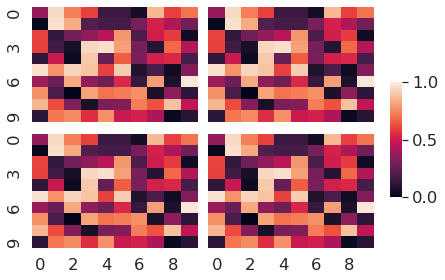

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.DataFrame(np.random.random((10,10,)))

fig, axn = plt.subplots(2, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, ax in enumerate(axn.flat):
    sns.heatmap(df, ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1,
                cbar_ax=None if i else cbar_ax)

fig.tight_layout(rect=[0, 0, .9, 1])

In [3]:
sparkSession = dfBasics.getSparkSession()

df = sparkSession.read.parquet('hdfs://hdfs-1.research.dev.seeburger.de/projects/ai/ssa/processcount/v3/*/*/*.parquet')

pfall = df.toPandas()
pfall = pfall[pfall['time'] != 'total']

In [4]:
# add single columns for datestring

ssa_timeformat = '%Y %m %d_%H:%M:%S'

def date(x,timeformat='%Y %m %d_%H:%M:%S'):
    return common.dt.datetime.strptime(x,timeformat)

def adddatecolumns(data,pf,column,timeformat='%Y %m %d_%H:%M:%S') :
    data['year'] = pf[column].apply(lambda x: date(x,timeformat).date().year)
    data['month'] = pf[column].apply(lambda x: date(x,timeformat).date().month)
    data['day'] = pf[column].apply(lambda x: date(x,timeformat).date().day)
    data['hour'] = pf[column].apply(lambda x: date(x,timeformat).time().hour)
    #data['minute'] = pf[column].apply(lambda x: date(x,timeformat).time().minute)
    #data['second'] = pf[column].apply(lambda x: date(x,timeformat).time().second)

In [5]:
#status = ['STOPPED_AFTER_ERROR','STOPPED', 'FAILED', 'FINISHED_ABNORMALLY', 'TIMEDOUT','TERMINATED_BY_USER', 'SUSPENDED']
_status = [e for e in pfall.columns.to_list() if e not in ('customerId','instanceId','time')]
keepcolumns = ['time', 'customerId', 'instanceId']
_instanceId = pd.unique(pfall['instanceId'])

In [6]:
def save():
    pfall1.to_parquet('/tmp/ssa.parquet', engine='pyarrow', compression='GZIP')

def processStatus(pfall, status):
    pfall1 = pfall[(pfall[status].notna()) & (pfall[status] > 0.0)][keepcolumns + [status]]
    instanceid_split = pd.DataFrame(pfall1['instanceId'].str.split('@',1).tolist(), columns = ['instance','host'])
    #pfall1 = pfall1 + instanceid_split
    pfall1['status'] = status
    pfall1['counter'] = pfall1[status].astype(int)
    del(pfall1[status])
    adddatecolumns(pfall1,pfall1,'time',timeformat='%Y-%m-%d %H:%M:%S')
    #del(pfall1['time'])
    return pfall1.reset_index().join(instanceid_split)

pfall1= pd.DataFrame()
for status_i in _status:
    pfall1 = pfall1.append(processStatus(pfall, status_i))
    
pfall1 = pfall1.sort_values(['year','month','day','hour']).reset_index()    
pfall1['customerId'] = pfall1['customerId'].astype(int)
pfall1['year'] = pfall1['year'].astype(int)
pfall1['month'] = pfall1['month'].astype(int)
pfall1['day'] = pfall1['day'].astype(int)
pfall1['hour'] = pfall1['hour'].astype(int)

_instances = pd.unique(pfall1['instance'])
_hosts = pd.unique(pfall1['host'])

In [151]:
import datetime

def label(graph,skip,rot) :
    for ind, label in enumerate(graph.get_xticklabels()):
        if ind % skip == 0:  # every 10th label is kept
            label.set_visible(True)
            label.set_rotation(rot)
        else:
            label.set_visible(False)

def get_ymdh(mdcountsall) :
    levels = []
    for i in range(mdcountsall.index.nlevels):
        levels.append(mdcountsall.index.get_level_values(i).astype(str))
    return levels

def make_2digits(blist):
    for n, b in enumerate(blist):
        if int(b) < 10:
             blist[n] = '0' + str(b)
    return blist

def get_ymd_string(a,b,c) :
    if isinstance(a, str) :
        return a + "-" + make_2digits([b])[0] + "-" + make_2digits([c])[0] 
    return a + "-" + pd.Index(make_2digits(b.tolist())) + "-" + pd.Index(make_2digits(c.tolist())) 


def get_ymdh_string(levels) :
    value = ''
    for level in levels:
        if len(value) > 1:
            value += "-"
        #value += level
        value += pd.Index(make_2digits(level.tolist()))
    return value    
    #return a + "-" + b + "-" + c + "-" + d

def aggregate(pfall,month,column='counter',groupby=['year','month','day','hour']) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(groupby)[column].sum()
    else :
        mdcountsall = pfall.groupby(groupby)[column].sum()  
    
    levels = get_ymdh(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymdh_string(levels)
        
    data2['year']  =  levels[0].astype(int) 
    data2['month'] =  levels[1].astype(int) 
    data2['day']   =  levels[2].astype(int)     
        
    data2['outcome'] =  mdcountsall.reset_index(level=0, drop=True).reset_index()[column].astype(int)    
    return data2.sort_values(['date']).reset_index()
        
def createData(pfall,month,column='counter',groupby=['year','month','day','hour']) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(groupby)[column].sum()
    else :
        mdcountsall = pfall.groupby(groupby)[column].sum()     
        
    levels = get_ymdh(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymdh_string(levels)
   
    data2['year']  =  levels[0].astype(int) 
    data2['month'] =  levels[1].astype(int) 
    data2['day']   =  levels[2].astype(int) 
    
    data2['outcome'] =  mdcountsall.reset_index(level=0, drop=True).reset_index()[column].astype(int)
        
    #for pivot table
    if 'hour' in groupby:
        data2['hours'] =  levels[3].astype(int) 
        data2['days']  =  levels[2].astype(int) 
    return data2

In [284]:
def fill(pda,year,month, full=True, first=False, last=False):        
    days = monthrange(year, month)[1]
    df = pda[(pda['month'] == month) & (pda['year'] == year)].sort_values(['day'])
    if len(df) == 0:
        return
    if full == True:
        _start_day = 1
        _end_day   = days
    else:
        _start_day = min(df['day'])
        _end_day   = max(df['day'])
        
    if first == True:     
        _start_day = min(df['day'])
        
    if last == True:     
        _end_day   = max(df['day'])    
        
    #print(year, month,days,_start_day, _end_day)
    #for day in range(1, days + 1):
    for day in range(_start_day, _end_day + 1):
        if len(df[df['day']==day]) == 0:
            #print(day)
            pda.loc[len(pda)]=[get_ymd_string(str(year),str(month),str(day)),year,month,day,0]
            
def check(_res):
    _start_year = min(pd.unique(_res['year']))
    _end_year = max(pd.unique(_res['year']))  
    _start_month = min(pd.unique(_res[_res['year']== _start_year]['month']))
    _end_month = max(pd.unique(_res[_res['year']== _end_year]['month']))
    _start_day = min(pd.unique(_res[(_res['year']== _start_year) & (_res['month'] == _start_month)]['day']))
    _end_day = max(pd.unique(_res[(_res['year']== _end_year) & (_res['month'] == _end_month)]['day']))
    
    #print(_start_year,_start_month,_end_year,_end_month)
    _end = 13
    first = True
    last  = False
    
    for year in range(_start_year,_end_year+1):
        if year == _end_year:
            _end = _end_month + 1
        for month in range(_start_month,_end):
            #print(year,month)
            if((month == _end_month) & (year == _end_year)):
                last = True
            fill(_res,year,month,full=True,first=first,last=last)
            first = False
        _start_month=1

In [266]:
from calendar import monthrange
import ipywidgets as widgets
from IPython.display import display, clear_output
style = {'description_width': '250px'}
layout = {'width': '600px'}

class visWidget(object):
    def __init__(self, **kwargs):
        allowed_keys = {'year', 'month', 'day','customerId','host','instance','status'}
        int_keys = {'year',  'day','customerId'}
        string_keys = {'month','host','instance','status'}
        for key in allowed_keys:
            self.__dict__.update({key : None})
        self.__dict__.update((k, int(v)) for k, v in kwargs.items() if k in int_keys and len(str(v)) > 0 )    
        self.__dict__.update((k, v) for k, v in kwargs.items() if k in string_keys) 
        
def check(_res):
    _start_year = min(pd.unique(_res['year']))
    _end_year = max(pd.unique(_res['year']))  
    _start_month = min(pd.unique(_res[_res['year']== _start_year]['month']))
    _end_month = max(pd.unique(_res[_res['year']== _end_year]['month']))

    _end = 13
    for year in range(_start_year,_end_year+1):
        for month in range(_start_month,_end):
            print(year,month)
            fill(_res,year,month)
        _start_month=1
        if year == (_end_year-1):
            _end = _end_month + 1  
            
def output_graph():
    with out:
        #clear_output()
        global _res
        _res = aggregate(pfall2,0,column='counter',groupby=['year','month','day'])
        del _res['index']
        check(_res)
        _res = _res.sort_values(['date']).reset_index()  

        _res1=_res
        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(1,1,1)
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True) 
        line1, =plt.plot(_res1.date, _res1['outcome'], label='month')
        label(ax,30,80)
        plt.legend();
        plt.show(fig)

def output_heatmap(month):
    #print(month)
    data2 = createData(pfall2,month, 'counter')
    piv = pd.pivot_table(data2, values="outcome",index=["hours"], columns=["days"], fill_value=0)
    
    _days = monthrange(int(year.value), month)[1]
    #piv.reindex(index=range(0,24), columns=range(1,_days + 1), fill_value=0)
    if len(piv) > 0:
        with out:
            #clear_output()
            #createHeatmap(piv, '',vmin=0,vmax=40)
            createHeatmap(piv, '')
    
def adapt():
    
    state = get_state()
    global _old_state
    if _old_state == None or state == _old_state:
        return
    _old_state = None
    
    with out:
        clear_output()
    
    
    global pfall2
    #pfall2 = pfall1
    pfall2 = pfall1[pfall1['customerId'] == customer_list.value]
    hosts_list.options     = pd.unique(pfall2['host'])
    #hosts_list.value = hosts_list.options[0]
    pfall2 = pfall2[(pfall2['host'] == hosts_list.value)]
    instances_list.options = pd.unique(pfall2['instance'])
    
    if len(year.value) > 0:
        pfall2 = pfall2[(pfall2['year'] == int(year.value))]
    
    #if len(month.value) > 0:
    #    pfall2 = pfall2[(pfall2['month'] == int(month.value))]
    
    if len(month.value) > 0:
        fromto = month.value.split('-')
        if len(fromto) == 1:
            pfall2 = pfall2[(pfall2['month'] == int(month.value))]
            output_heatmap(int(month.value))
        else:
            del(pfall2['level_0'])
            _res=[]
            for m in range(int(fromto[0]), int(fromto[1]) + 1):
                #output_heatmap(m)
                _res.append(get_month(pfall2, year=int(year.value), month=m))
            pfall2 = pd.concat(_res, ignore_index=True).reset_index()
            output_graph()
    else:
        output_graph()
    
    pfall2 = pfall2[(pfall2['instance'] == instances_list.value)]
    
    status_list.options = pd.unique(pfall2['status'])
    pfall2 = pfall2[(pfall2['status'] == status_list.value)]
      
    _old_state=get_state()
    #print(state.__dict__)
    
def get_state():
    return visWidget(year=year.value, month=month.value, day=day.value,customerId=customer_list.value,host=hosts_list.value,instance=instances_list.value,status=status_list.value)
    
def hosts_liston_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        adapt()    
        #instances_list.options = instances = pd.unique(pfall2[pfall2['host'] == hosts_list.value]['instance'])
        
def on_value_submit_month(change):
    adapt()
    #print(int(change.value))

In [113]:
#.str.split('@',1).tolist()
"5-7".split('-')

['']

# widget

In [289]:
_instances_month = pd.unique(pfall1['instance'])
_hosts_month     = pd.unique(pfall1['host'])

year   = widgets.Text(description = 'year',value = '2019', style=style, layout=layout,disabled=False)     
month  = widgets.Text(description = 'month',value = '', style=style, layout=layout,disabled=False) 
day    = widgets.Text(description = 'day',value = '', style=style, layout=layout,disabled=False) 
month.on_submit(on_value_submit_month)
year.on_submit(on_value_submit_month)
hosts_list = widgets.Dropdown(description='host',options=_hosts_month, style=style, layout=layout,disabled=False)
hosts_list.observe(hosts_liston_change) 
instances_list = widgets.Dropdown(description='instance',options=_instances_month, style=style, layout=layout,disabled=False)
instances_list.observe(hosts_liston_change) 
status_list = widgets.Dropdown(description='status',options=[], style=style, layout=layout,disabled=False)
status_list.observe(hosts_liston_change) 
customer_list = widgets.Dropdown(description='customer',options=pd.unique(pfall1['customerId']), style=style, layout=layout,disabled=False)
customer_list.observe(hosts_liston_change) 
#adapt()
_old_state = get_state()
out = widgets.Output()
display (year,month,day,customer_list,hosts_list,instances_list,status_list,out)

Text(value='2019', description='year', layout=Layout(width='600px'), style=DescriptionStyle(description_width=…

Text(value='', description='month', layout=Layout(width='600px'), style=DescriptionStyle(description_width='25…

Text(value='', description='day', layout=Layout(width='600px'), style=DescriptionStyle(description_width='250p…

Dropdown(description='customer', layout=Layout(width='600px'), options=(10823, 8904, 87772, 120489, 105666, 11…

Dropdown(description='host', layout=Layout(width='600px'), options=('SRVPUE04', 'SRVFRE03', 'SRVVIB685', 'BIS6…

Dropdown(description='instance', layout=Layout(width='600px'), options=('CENTRAL', 'SRVVIB685', 'NODE2_SRVVIB5…

Dropdown(description='status', layout=Layout(width='600px'), options=(), style=DescriptionStyle(description_wi…

Output()

In [291]:
#_res[(_res['month'] == 6) & (_res['year'] == 2019)]
_old_state.__dict__

{'instance': 'INSTANCE_NDL-NL-DT-016',
 'year': None,
 'host': 'NDL-NL-BIS-211',
 'day': None,
 'status': 'FINISHED',
 'month': '',
 'customerId': 120489}

# LSTM

In [292]:
import numpy as np
import AnomalyDetectionLSTMAutoencoder

_res1=_res
TIME_STEPS = 30

def getThreshold(perc):
    anomalyEnc.test_score_df      = anomalyEnc.testScoreDF(anomalyEnc.model, 0.0, anomalyEnc.X_test, anomalyEnc.test)
    fig = plt.figure(figsize=(12,6))
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
    data = plt.plot(anomalyEnc.test_score_df.index, anomalyEnc.test_score_df.loss, label='loss')
    y=plt.getp(data[0],'ydata')
    plt.show(fig)
    
    #threshold_X = np.max(y) - 0.025
    return perc * np.max(y)

def doit():
    anomalyEnc = AnomalyDetectionLSTMAutoencoder.AnomalyDetectionLSTMAutoencoder(TIME_STEPS = 30)
    anomalyEnc.initAndTrain(_res1,0.7)
    return anomalyEnc

out2 = widgets.Output()

anomalyEnc = None

with out2:
    anomalyEnc = doit()   

In [293]:
import base.anomaly as anomaly


def scatterplot(index, values,label):
    return sns.scatterplot(
      x=index,
      y=values,
      color=sns.color_palette()[3],
      s=152,
      label=label
    )
    
def plot_test(test,scaler,anomalies,titlestring):

    fig = plt.figure(figsize=(12,6))
    
    plt.plot(
      test[TIME_STEPS:].index, 
      scaler.inverse_transform(test[TIME_STEPS:].close), 
      label='msg count'
    );

    ax = scatterplot(anomalyEnc.anomalies.index, anomalyEnc.scaler.inverse_transform(anomalyEnc.anomalies['close']), 'anomaly')  
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
    plt.xticks(rotation=25)
    plt.legend();

    label(ax,5,80)
    plt.title(titlestring)
    plt.show(fig)

out3 = widgets.Output()

def on_value_submit_percent(change):
    with out2:
        threshold_X = getThreshold(float(percent.value))
        anomalyEnc.evaluateAnomalies(threshold_X)
        clear_output()
    
    with out3:
        clear_output()
        sender = 0
        titlestring ="endpoint (sending) : " + str(sender) + " ( trained: " +  anomalyEnc.train.index[0] + " -- " + anomalyEnc.train.index[len(anomalyEnc.train.index)-1] + " )"
        plot_test(anomalyEnc.test,anomalyEnc.scaler,anomalyEnc.anomalies,titlestring)

percent   = widgets.Text(description = 'percent',value = '0.985', style=style, layout=layout,disabled=False)    
percent.on_submit(on_value_submit_percent)

display(percent,out3)

Text(value='0.985', description='percent', layout=Layout(width='600px'), style=DescriptionStyle(description_wi…

Output()

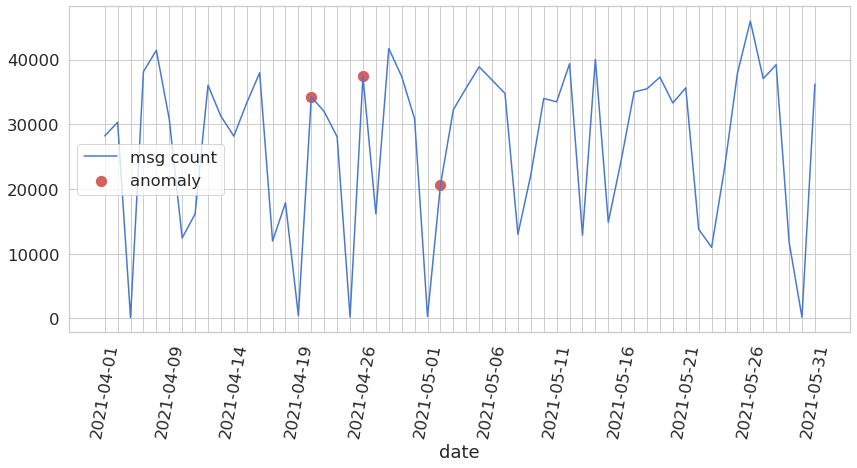

In [99]:
_a = get_month(_res, year=2021, month=4)
_b = get_month(_res, year=2021, month=5)
_c = pd.concat([_a, _b], ignore_index=True).reset_index()

fig = plt.figure(figsize=(14,6))
plt.plot(_c['date'], _c['outcome'], label='msg count');
#plt.xticks(rotation=25)
ax = scatterplot(anomalyEnc.anomalies.index, anomalyEnc.scaler.inverse_transform(anomalyEnc.anomalies['close']), 'anomaly')   
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True) 
label(ax,5,80)
plt.show(fig)

In [257]:
#hosts_list.value
#pfall2[pfall2['day'] == 2]

#pd.unique(pfall1[(pfall1['host']==_old_state.__dict__['host']) & (pfall1['customerId'] ==_old_state.__dict__['customer'])]['instance'])

#pd.unique(pfall1[(pfall1['customerId'] ==_old_state.__dict__['customer'])]['host'])

#pd.unique(pfall1[(pfall1['host']==_old_state.__dict__['host'])]['instance'])

#_old_state.__dict__['customer']
#hosts_list.options
#_old_state.__dict__['customer']

#pd.unique(pfall1[(pfall1['customerId'] ==_old_state.__dict__['customer']) & (pfall1['host']==_old_state.__dict__['host'])]['instance'])


#pd.unique(pfall1[(pfall1['customerId'] ==_old_state.__dict__['customer'])]['instance'])


#pfall1[(pfall1['customerId'] ==_old_state.__dict__['customer'])]

#pd.unique(pfall1[(pfall1['customerId'] ==_old_state.__dict__['customerId']) & (pfall1['host']==_old_state.__dict__['host'])]['instance'])
#pd.unique(pfall1[(pfall1['customerId'] ==_old_state.__dict__['customerId']) & (pfall1['instance'] ==_old_state.__dict__['instance']) & (pfall1['host']==_old_state.__dict__['host'])]['status'])


#pfall1[(pfall1['customerId'] ==_old_state.__dict__['customerId']) & (pfall1['host']==_old_state.__dict__['host'])]
del(_res['index'])
#_res.columns
check(_res)
#pda.loc[len(pda)]=[get_ymd_string(str(year),str(month),str(day)),year,month,day,0]
#_res[_res['month'] == 10]

In [ ]:
#_res
#_res[_res['month'] == 8].sort_values(['date'])

#_res.sort_values(['date'])[_res['month'] == 8]

_res[_res['month'] == 7]

In [239]:
#_res
pda = _res
month = 12
year = 2019

days = monthrange(year, month)[1]
pda = pda[(pda['month'] == month) & (pda['year'] == year)].sort_values(['day'])
_start_day = min(pda['day'])
_end_day   = max(pda['day'])
print(year, month,days,_start_day, _end_day)

2019 12 31 1 18


In [233]:
#_res[_res['month'] == 10]

_start_year = min(pd.unique(_res['year']))
_end_year = max(pd.unique(_res['year']))  
_start_month = min(pd.unique(_res[_res['year']== _start_year]['month']))
_end_month = max(pd.unique(_res[_res['year']== _end_year]['month']))

print(_start_year,_start_month,_end_year,_end_month)


2019 11 2019 12


In [189]:
pfall[(pfall['instanceId'] == 'NODE1_SRVVIB500A@BIS6PROD') & (pfall['time'] == '2019-08-02 00:00:00')]
#pfall1[(pfall1['instanceId'] == 'NODE1_SRVVIB500A@BIS6PROD') & (pfall1['year'] == 2019) & (pfall1['month'] == 8) & (pfall1['day'] == 2)]
#pfall1

,customerId,instanceId,time,FINISHED,STOPPED_AFTER_ERROR,STOPPED,FAILED,FINISHED_ABNORMALLY,TIMEDOUT,TERMINATED_BY_USER,SUSPENDED
42715,10823,NODE1_SRVVIB500A@BIS6PROD,2019-08-02 00:00:00,1,0,0,0,0,0,0,0.0
42716,10823,NODE1_SRVVIB500A@BIS6PROD,2019-08-02 00:00:00,846,0,0,0,0,0,0,0.0


In [ ]:
#_res
pd.unique(pfall1[pfall1['customerId'] == 30905]['host'])
#instances_list.options

pfall2 = pfall1[pfall1['customerId'] == customer_list.value]
hosts_list.options     = pd.unique(pfall2['host'])
instances_list.options = pd.unique(pfall2['instance'])


#pd.unique(pfall2['instance'])
instances_list.options



In [ ]:
#pd.unique(pfall1['status'])
#pfall1[(pfall1['status'] == status[3]) & (pfall1['year'] == 2019) & (pfall1['month'] == 7) & (pfall1['day'] == 31) & (pfall1['instanceId'] == _instanceId[0])]

#pfall1[(pfall1['status'] == status[3]) & (pfall1['year'] == 2019) & (pfall1['month'] == 7) & (pfall1['instance'] == _instances[2])]

#_hosts, _instances

pfall2

In [ ]:
#pd.unique(pfall['year']), len(pfall)
#pfall[pfall['FAILED'] != 0.0]
#pfall[(pfall['STOPPED_AFTER_ERROR'].notna()) & (pfall['STOPPED_AFTER_ERROR'] > 0.0)]

#


#keepcolumns = ['customerId', 'hostname', 'year', 'month', 'day', 'hour', 'minute', 'second']

#'time', 'counter',


#
#pfall1

#


#pfall[pfall['status'] == 'FAILED'][keepcolumns + ['FAILED']]
#pfall

pfall1[pfall1['status'] == 'FAILED']

pfall.loc[(pfall['FAILED'].notna()) & (pfall['FAILED'] == 0.0)]


In [ ]:

pd.unique(pfall2['status'])
 #createData(pfall2,9,groupby=['year','month','day','hour'])

In [ ]:


#pd.unique(pfall['hostname'])
data2 = createData(pfall2,4, 'counter')
piv = pd.pivot_table(data2, values="outcome",index=["hours"], columns=["days"], fill_value=0)
if len(piv) > 0:
    with out:
        clear_output()
        createHeatmap(piv, '')
    
#pd.unique(pfall1['month'])     

In [ ]:
from calendar import monthrange
_days = monthrange(2020, 4)[1]
piv.reindex(index=range(0,24), columns=range(1,_days + 1), fill_value=0)


In [ ]:
#pfall1[(pfall1['day']==1) & (pfall1['month']==1)].groupby(['year','month','day','hour']).sum()
pfall1[(pfall1['day']==1) & (pfall1['month']==1)].sort_values(['hour'])
pfall1[(pfall1['day']==1) & (pfall1['month']==2)].sort_values(['hour']).groupby(['year','month','day'])['counter'].sum()
pfall1[(pfall1['month']==2)].sort_values(['hour']).groupby(['year','month','day'])['counter'].sum()
pfall1[(pfall1['month']==3)].groupby(['year','month','day','hour'])['counter'].sum()

#pfall1.groupby(['year','month','day','hour']).sum()

In [ ]:
#data = createData(pfall1,0)
pfall1 = pfall[(pfall['year']==2020) & (pfall['hostname'] == hostnames[0])]
pfall1 = pfall[(pfall['hostname'] == hostnames[1])]
data = createData(pfall1,0,groupby=['year','month','day'])

fig = plt.figure(figsize=(24,12))
ax = fig.add_subplot(1,1,1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True) 
line1, =plt.plot(data.date, data['outcome'], label='loss')
label(ax,15,80)
plt.legend();

In [64]:
from calendar import monthrange
import datetime
datetime.date(2032, 12, 31).isocalendar()[1]

def get_year(pda, year=2020):
    return pda[(pda['year'] == year)]

def add_weeek(df):
    datetime.date(2032, 12, 31).isocalendar()[1]
    
def get_month(pda, year=2020, month=1):
    return pda[(pda['month'] == month) & (pda['year'] == year)]

def is_complete(pda, year=2020, month=1):
    mm = pda[(pda['month'] == month) & (pda['year'] == year)]
    if len(mm) > 0:
        return monthrange(year, month)[1] == len(mm)
    return None
    
def check_complete(pda, year=2020):
    for m in range(1, 13):
        mm = pda[(pda['month'] == m) & (pda['year'] == year)]
        if len(mm) > 0:
            print(m,monthrange(year, m)[1] == len(mm))



In [104]:
_res = aggregate(pfall2,0,column='counter',groupby=['year','month','day'])
del _res['index']
_res = _res.sort_values(['date']).reset_index()    

# rest

In [ ]:
#_res1=get_month(_res, year=2020, month=9) 
#_res1= get_year(_res, year=2021)
_res1=_res

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True) 
line1, =plt.plot(_res1.date, _res1['outcome'], label='month')
label(ax,30,80)
plt.legend();

In [ ]:
import base.anomaly as anomaly
sender = 0
titlestring ="endpoint (sending) : " + str(sender) + " ( trained: " +  anomalyEnc.train.index[0] + " -- " + anomalyEnc.train.index[len(anomalyEnc.train.index)-1] + " )"
plot_test(anomalyEnc.test,anomalyEnc.scaler,anomalyEnc.anomalies,titlestring)

In [ ]:
X = anomalyEnc.train[[anomalyEnc.OUTCOME]]['close']
y = anomalyEnc.train['close']
#len(anomalyEnc.X_train[0]), type(anomalyEnc.y_train[0])
#X.head(), y.head()
time_steps = 30
i=334
v = X.iloc[i:(i + time_steps)].values
v,y[i + time_steps],i + time_steps

In [ ]:
data = sns.distplot(anomalyEnc.train_mae_loss, bins=50, kde=True).get_lines()[0].get_data()

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 

plt.plot(anomalyEnc.test_score_df.index, anomalyEnc.test_score_df.loss, label='loss')
plt.plot(anomalyEnc.test_score_df.index, anomalyEnc.test_score_df.threshold, label='threshold')
#plt.xticks(rotation=25)
#plt.legend();

In [ ]:
_res = aggregate(pfall1,0,column='counter',groupby=['year','month','day'])
del _res['index']
_res = get_month(_res, year=2021, month=3) 
fill(_res,2021,3) 
_res = _res.sort_values(['date']).reset_index()


fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True) 
line1, =plt.plot(_res.date, _res['outcome'], label='month')
label(ax,1,80)
plt.legend();

In [ ]:
import numpy as np
x = np.linspace(0, 2*np.pi, 100)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
line1, = ax.plot(x, np.sin(x), label='') # X range: 0 to 2pi
ax.set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
line2, = ax.plot(1.5*x, np.sin(x), label='') # X range: 0 to 3pi

In [ ]:
#pfall[pfall['TIMEDOUT'] != 0]
#pfall.columns[3] = 'counter'
_plist = pfall.columns.to_list()
#_plist[3] = 'counter'
#pfall.columns = _plist
_plist